# Inteligencia Artificial. Examen Final

Instrucciones:
* Por favor, complete las tareas de este notebook. Deberá enviar este notebook, así como una versión en PDF, a la plataforma Univirtual.
* Para crear el PDF, vaya a Archivo > Descargar como. Puede exportar a PDF mediante Latex, o exportar a HTML y luego imprimir a PDF.
* Añada una explicación clara de su enfoque y una interpretación detallada de sus resultados para cada subpregunta. Para ello, utilice celdas Markdown.

* Añada a continuación los nombres de todos los miembros del equipo.

**Integrantes:**

1.   Integrante 1: Stefano Imanol Ramírez Uribe
2.   Integrante 2: Jhiro Franky Cisnero Sanchez

# 1 Técnicas basadas en regiones para la segmentación de imágenes (3 puntos)


La segmentación de imágenes es el proceso de **asignar una etiqueta a cada píxel en una imagen** de modo que los píxeles con la misma etiqueta compartan ciertas características. Como consecuencia, se producen regiones cuyos píxeles tienen propiedades similares, por ejemplo: intensidad, color, textura o ubicación en la imagen. El resultado de la segmentación de imágenes puede ser:

* un conjunto de segmentos que cubren colectivamente toda la imagen (por ejemplo, umbralización),
* o un conjunto de contornos extraídos de la imagen (por ejemplo, detección de bordes).


<img src="./images/image-segmentation-example.png" width="550"/>

Conceptualmente, existen dos enfoques tradicionales para la segmentación de imágenes:

* **Segmentación de arriba hacia abajo (top-down)**, que considera que los píxeles del mismo objeto en la escena deben estar en la misma región segmentada.
* **Segmentación de abajo hacia arriba (bottom-up)**, que establece que los píxeles similares en la imagen deben estar en la misma región segmentada.


<center><img src="./images/bottom-up_top-down-segmentation.png" width="500"/>Imagen adaptada de <a href="myfootnote1">[1]</a></center>


Aquí ponemos el foco en los enfoques de segmentación de abajo hacia arriba. Los métodos que siguen este enfoque pueden agruparse en:

* **Técnicas basadas en contornos**, que intentan identificar las regiones de la imagen detectando sus contornos.
* **Técnicas basadas en regiones**, que agrupan píxeles que son similares entre sí.

En este notebook, cubriremos ambas familias de técnicas, comenzando con dos métodos populares basados en regiones:

* Expectation-Maximization


## Contexto del problema - Cuantización de color


<img src="./images/color-quantization.jpg" width="800"/>


La cuantización de color es el proceso de reducir el número de colores distintos en una imagen mientras se preserva su apariencia de color lo mejor posible. Tiene muchas aplicaciones, como la compresión de imágenes (por ejemplo, GIFs) o [content-based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval).


Las técnicas de segmentación de imágenes pueden utilizarse para lograr la cuantización de color, ¡veamos cómo funciona!


## 1.2 Expectation-Maximization (EM)

**Expectation-Maximization (EM)** es la generalización del algoritmo K-means, donde cada clúster está representado por una distribución Gaussiana, parametrizada por una media y una matriz de covarianza, en lugar de solo un centroide. Es un *clustering suave* ya que no toma decisiones *duras* sobre si un píxel pertenece o no a un clúster, sino que calcula la probabilidad de que ese píxel pertenezca a cada clúster $C_j$, that is, $p(x|C_j) \sim N(\mu_j,\Sigma_j)$.  Esto implica que en cada iteración del algoritmo no solo se refina la media de cada clúster (como en K-means), sino también sus matrices de covarianza.

Antes de entrar en detalle sobre la teoría detrás de EM, vale la pena ver cómo se desempeña en el problema de la placa del auto. OpenCV proporciona una clase que implementa la funcionalidad necesaria para aplicar segmentación EM a una imagen, llamada [cv2.ml.EM](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html). Todos los métodos y parámetros están completamente detallados en la documentación, por lo que es una buena idea echarle un vistazo.


In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats  # si usarás EM




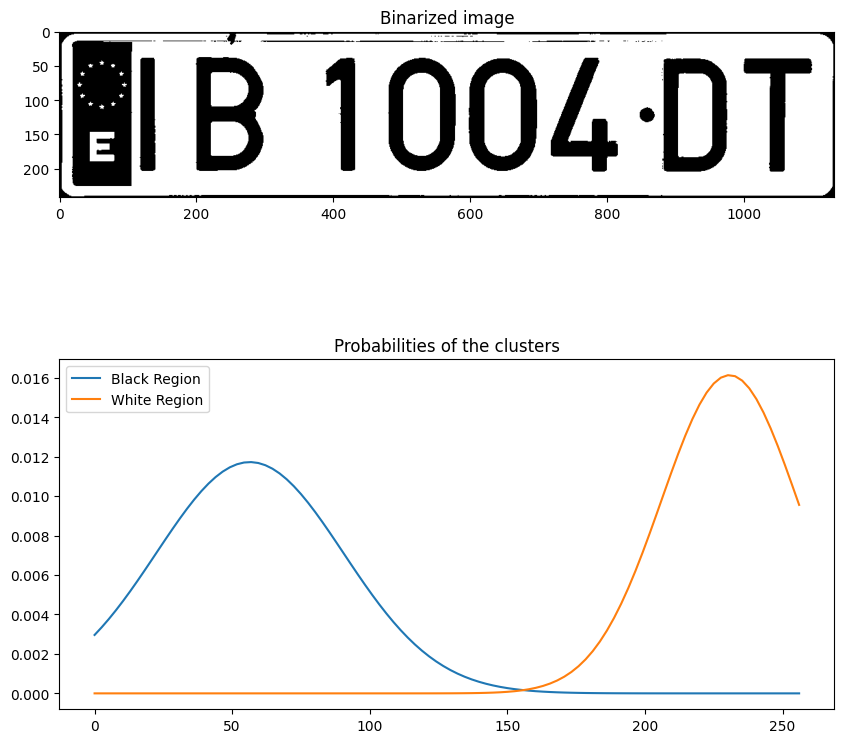

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
cv2.setRNGSeed(5)

# Define parameters
n_clusters = 2
covariance_type = 0 # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
n_iter = 10
epsilon = 0.2

# Create EM empty object
em = cv2.ml.EM_create()

# Set parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)
images_path = './images/' 

# Read grayscale image
image = cv2.imread(images_path + "plate.jpg",0)

# Flatten image
flattened_img = image.reshape((-1,1))
flattened_img = np.float32(flattened_img)

# Apply EM
_, _, labels, _ = em.trainEM(flattened_img)

# Reshape labels to image size (binarization)
binarized = labels.reshape((image.shape))

# Show original image
plt.subplot(2,1,1)
plt.title("Binarized image")
plt.imshow(binarized, cmap="gray")

# --------------- Gaussian visualization ---------------

plt.subplot(2,1,2)
plt.title("Probabilities of the clusters")

# Get means and covs (for grayscale 1D both)
means = em.getMeans()
covs = em.getCovs()

# Get standard deviation as numPy array
sigmas = np.sqrt(covs)
sigmas = sigmas[:,0,0]

# Cast list to numPy array
means = np.array(means)[:,0]

# Plot Gaussians
x = np.linspace(0, 256, 100)
plt.plot(x, stats.norm.pdf(x, loc = means[0], scale = sigmas[0]))
plt.plot(x, stats.norm.pdf(x, loc = means[1], scale = sigmas[1]))
plt.legend(['Black Region', 'White Region'])

plt.show()

Como puedes ver, aunque en OpenCV **k-means** está implementado como un método y **EM** como una clase, ambos operan de forma similar. En el ejemplo anterior, estamos segmentando una placa de automóvil en dos clústeres, y **cada clúster está definido por una distribución Gaussiana** (una distribución Gaussiana para la región negra y otra para la región blanca). Esta es la base de EM, pero **¿cómo funciona?**

EM es un algoritmo iterativo que se divide en dos pasos principales:

* Primero, **inicializa la media y la matriz de covarianza de cada uno de los \$K\$ clústeres**. Típicamente, se eligen al azar (\$\mu\_j\$, \$\Sigma\_j\$) y \$P(C\_j)\$ (probabilidad a priori) para cada clúster \$j\$.
* Luego, se mantiene iterando realizando los pasos de Expectación-Maximización hasta que se cumpla algún criterio de parada (por ejemplo, cuando no ocurre ningún cambio en una iteración completa):

  1. **Paso de Expectación:** calcular las probabilidades de que cada punto pertenezca a cada clúster, es decir, \$p(C\_j|x\_i), \forall i \in \text{data}\$:

  $$
  P(C_j|x_i)=\frac{p(x_i|C_j)p(C_j)}{p(x_i)}=\frac{p(x_i|C_j)p(C_j)}{\sum_i p(x_i|C_j)p(C_j)}
  $$

  Se asigna \$x\_i\$ al clúster \$C\_j\$ con la mayor probabilidad \$P(C\_j|x\_i)\$.
  
  2\. **Paso de Maximización:** se reestiman los parámetros de los clústeres ((\$\mu\_j\$, \$\Sigma\_j\$) y \$p(C\_j)\$) para cada clúster \$j\$ conociendo los resultados del paso de expectación, lo que también se conoce como *Estimación de Máxima Verosimilitud (MLE)*:

  $$
  \mu_j=\frac{\sum_i p(C_j|x_i)x_i}{\sum_i p(C_j|x_i)} \\
  \Sigma_j = \frac{\sum_i p(C_j|x_i)(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_i p(C_j|x_i)} \\
  p(C_j)=\sum_i p(C_j|x_i)p(x_i)=\frac{\sum_i p(C_j|x_i)}{N}
  $$

  *Nota que si no se dispone de otra información, se considera que las probabilidades a priori son igualmente probables.*


<img src="./images/em.gif" width="400" align="center">
<center><i>Ejemplo de una ejecución del algoritmo EM con dos clústeres, mostrando la evolución de sus distribuciones Gaussianas asociadas.</i></center>


¿No te recuerda al algoritmo K-means? **¿Cuál es la diferencia entre ellos?**

La principal diferencia es que **K-means utiliza la distancia euclidiana** para medir qué tan cerca está un punto de un clúster. En EM se utiliza una distancia en la que **cada dimensión se pondera** según la **matriz de covarianza** de cada clúster, lo que se conoce como **distancia de Mahalanobis**. Además, en K-means un punto de datos **pertenece o no** a un clúster, mientras que en EM un punto de datos tiene una **probabilidad mayor o menor** de pertenecer a un clúster. La siguiente tabla resume otras diferencias:


<table width="500px">
    <tr>
        <td style="text-align:center;"></td>
        <td style="text-align:center;"><b>K-means</b></td>
        <td style="text-align:center;"><b>EM</b></td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Representación del clúster</b></td>
        <td style="text-align:center;">Media</td>
        <td style="text-align:center;">Media y (co)varianza</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Inicialización del clúster</b></td>
        <td style="text-align:center;">Selección aleatoria de K medias</td>
        <td style="text-align:center;">Inicialización de K distribuciones Gaussianas <br />($\mu_j$, $\Sigma_j$) y $P(C_j)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Expectación:</b> <br /> Estimar el clúster de cada dato</td>
        <td style="text-align:center;">Asignar cada punto a la media más cercana</td>
        <td style="text-align:center;">Calcular $P(C_j|x_i)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Maximización:</b> <br /> Reestimar los parámetros del clúster</td>
        <td style="text-align:center;">Calcular medias de los clústeres actuales</td>
        <td style="text-align:center;">Calcular nuevos ($\mu_j$, $\Sigma_j$) y $P(C_j)$ para cada clúster $j$</td>
    </tr>
</table>


Si aún tienes curiosidad sobre EM, puedes encontrar [aquí](https://www.youtube.com/watch?v=REypj2sy_5U) una explicación más detallada.


#### <font color="orange">Cápsula OpenCV</font>

Volviendo al código, al trabajar con EM debemos especificar un tipo de matriz de covarianza utilizando [`em.setCovarianceMatrixType()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a8b383c62697eac9a972931674790f6cd). Además, cuando aplicas [`em.trainEM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a5a6a7badbc0c85a8c9fa50a41bf1bcd2), este no devuelve el centroide de los clústeres; es posible obtenerlos llamando a [`em.getMeans()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#acec62dd55c06711c81d741c2d96603d1).


### **<span style="color:green"><b><i>TAREA 2: Cuantización de color con el espacio de color YCrCb</i></b></span>**

En el siguiente ejemplo, la cuantización de color se realiza utilizando el espacio de color YCrCb (más información sobre este espacio en el apéndice 2) en lugar de RGB. De este modo, la cuantización de color se aplica solo a las dos bandas de color, omitiendo la banda en escala de grises. ¡Veamos cómo funciona!

**¿Qué hacer?** Entender y probar el siguiente código.


In [3]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

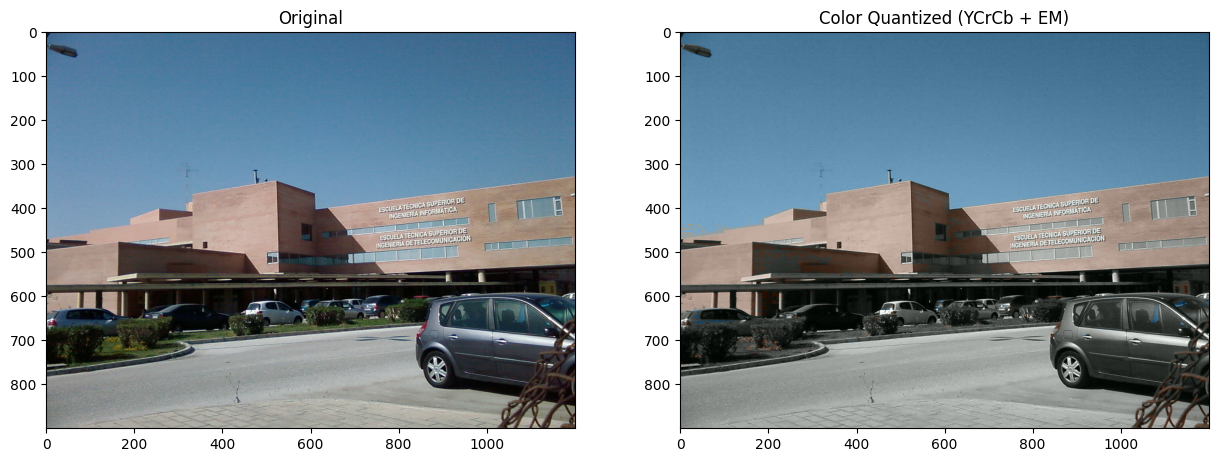

In [4]:
# Assignment 2
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
cv2.setRNGSeed(5)

# Define parameters

n_clusters = 3 # Don't modify this parameter for this exercise

covariance_type = 0 # 0: Spherical covariance matrix. 1: Diagonal covariance matrix. 2: Full covariance matrix
n_iter = 10
epsilon = 0.2

# Create EM empty object

em = cv2.ml.EM_create()

# Set parameters

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Read color image

image = cv2.imread(images_path + "etsii.jpg")

# Convert to YCrCb

image_YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

# Take color bands (2 lasts)

Y_band = image_YCrCb[:, :, 0]
color_bands = image_YCrCb[:, :, 1:]  # Cr y Cb

# Flatten image

h, w, _ = image.shape
flattened = color_bands.reshape((-1, 2)).astype(np.float32)

# Apply EM

_, _, labels, _ = em.trainEM(flattened)

# Colour resultant labels

centers = em.getMeans()
quantized = centers[labels.flatten().astype(int)]

# Reshape to original shape

quantized = quantized.reshape((h, w, 2))

# Merge original first band with quantized color bands

quantized_YCrCb = np.zeros_like(image_YCrCb)
quantized_YCrCb[:, :, 0] = Y_band
quantized_YCrCb[:, :, 1:] = quantized

# Cast to unsigned data dype

quantized_YCrCb = np.clip(quantized_YCrCb, 0, 255).astype(np.uint8)

# Reconvert to RGB

quantized_BGR = cv2.cvtColor(quantized_YCrCb, cv2.COLOR_YCrCb2BGR)

# Show original image

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Show resultant image

plt.subplot(1, 2, 2)
plt.title("Color Quantized (YCrCb + EM)")
plt.imshow(cv2.cvtColor(quantized_BGR, cv2.COLOR_BGR2RGB))

plt.show()

### <font color="blue"><b><i>Reflexionando sobre ello (2)</i></b></font>

Una vez que hayas entendido el código anterior, **responde las siguientes preguntas:**

* ¿Por qué los resultados obtenidos son tan buenos usando solo 3 clústeres?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Muchas regiones en la imagen tienen colores similares, por lo que 3 clústeres bastan para representar adecuadamente la variación cromática.</i></p>

* ¿Qué compresión sería mejor en términos de espacio en memoria: una compresión a 16 colores en una imagen RGB o una compresión a 4 colores en una imagen YCrCb?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>La compresión a 4 colores en una imagen YCrCb sería más eficiente en términos de espacio en memoria, ya que solo se reducen las componentes de color (Cr y Cb), manteniendo la luminancia intacta. Esto permite reducir el número de colores percibidos sin sacrificar detalles visuales importantes. En contraste, una compresión a 16 colores en RGB afecta directamente a toda la información de la imagen, incluyendo bordes y contraste, lo que puede degradar notablemente la calidad visual y resultar menos eficiente perceptualmente.</i></p>


### Profundizando en las matrices de covarianza

Existen 3 tipos de matrices de covarianza: **covarianzas esféricas**, **covarianzas diagonales** o **covarianzas completas**:


<img src="./images/ellipses.png" width="700" align="center">




### **<span style="color:green"><b><i>TAREA 3: Visualizando los clústeres con EM</i></b></span>**

A continuación, tienes un código para visualizar los clústeres en el espacio de color YCrCb utilizando EM.

**¿Qué hacer?** Ejecuta el ejemplo anterior modificando el tipo de covarianza en el algoritmo EM y visualiza los cambios utilizando el siguiente código.


In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def PlotEllipse(fig, ax, mean, cov, nsig=2, **kwargs):
    """
    Dibuja una elipse representando una distribución gaussiana 2D.
    - mean: vector de medias (shape (2,1) o (2,))
    - cov: matriz de covarianza (2x2)
    - nsig: número de desviaciones estándar
    """
    if mean.shape != (2,):  # por si viene como columna
        mean = mean.ravel()

    # Calcular valores propios y vectores propios (para forma y orientación)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Ángulo de rotación de la elipse (en grados)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Ancho y alto de la elipse
    width, height = 2 * nsig * np.sqrt(vals)

    # Crear y agregar la elipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      edgecolor=kwargs.get('color', 'black'), facecolor='none')
    ax.add_patch(ellipse)


In [6]:
# Reconstruir res a partir de labels y centers
centers = em.getMeans()
res = centers[labels.flatten().astype(int)]
res = res.reshape((image.shape[0], image.shape[1], 2))


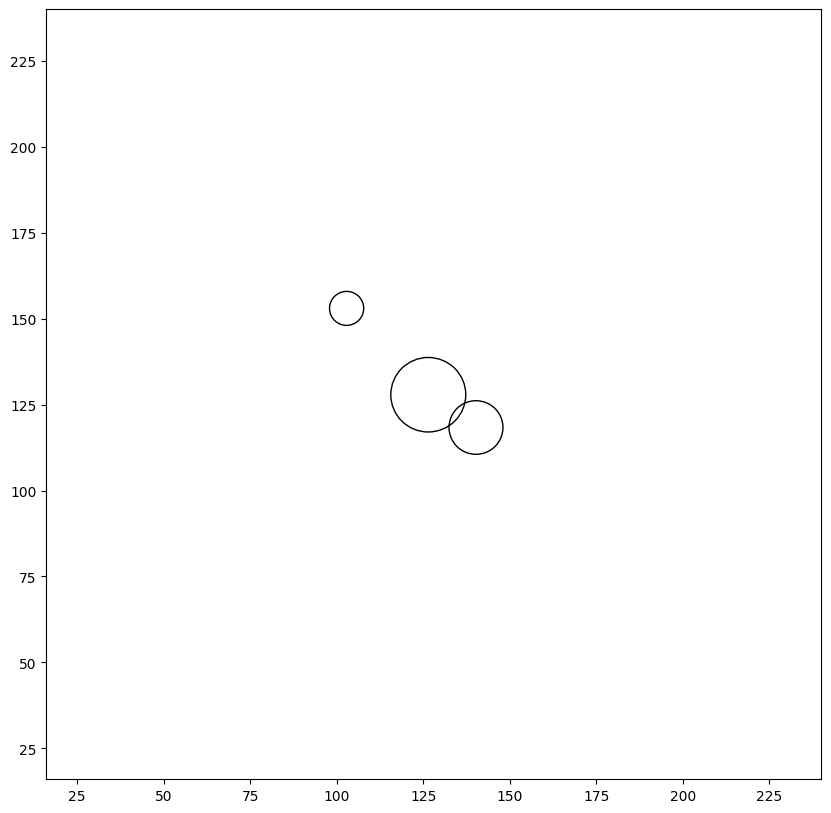

In [7]:
# Assignment 3
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

# Get means (2D) and covariance matrices (2x2)
means = np.array(em.getMeans())
covs = np.array(em.getCovs())

# Create figure
fig, ax = plt.subplots()
plt.axis([16, 240, 16, 240])

# Get cluster centers from res
unique_colors = np.unique(res.reshape(-1, 2), axis=0)

# Get points contained in each cluster
cluster_1 = np.any(color_bands == np.unique(res, axis=0)[0, :], axis=2)
cluster_2 = np.any(color_bands == np.unique(res, axis=0)[1, :], axis=2)
cluster_3 = np.any(color_bands == np.unique(res, axis=0)[2, :], axis=2)
cluster_1 = color_bands[cluster_1]
cluster_2 = color_bands[cluster_2]
cluster_3 = color_bands[cluster_3]

# Plot them
plt.plot(cluster_1[:, 0], cluster_1[:, 1], 'go')  # Cr, Cb
plt.plot(cluster_2[:, 0], cluster_2[:, 1], 'ro')
plt.plot(cluster_3[:, 0], cluster_3[:, 1], 'bo')

# Plot ellipses representing covariance matrices
PlotEllipse(fig, ax, np.vstack(means[0, :]), covs[0, :, :], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[1, :]), covs[1, :, :], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[2, :]), covs[2, :, :], 2, color='black')

fig.canvas.draw()



### <font color="blue"><b><i>Reflexionando sobre ello (3)</i></b></font>

**Responde las siguientes preguntas** sobre cómo funciona el clustering en EM:

* ¿Cuáles son las diferencias entre cada tipo de covarianza?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Cuando se usa una covarianza completa (tipo 1), cada componente gaussiano tiene su propia matriz de covarianza, lo que permite modelar elipses de cualquier forma y orientación, adaptándose bien a clusters alargados o inclinados. Con la covarianza diagonal (tipo 2), las elipses solo se expanden a lo largo de los ejes, ya que no se considera la correlación entre variables, aunque se permite varianza distinta por eje. Por último, la covarianza esférica (tipo 0) restringe los clusters a círculos, es decir, misma varianza en todas las direcciones, lo cual simplifica el modelo pero reduce su capacidad para representar formas complejas.</i></p>

* ¿Qué tipo de covarianza hace que EM sea equivalente a k-means?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>El modelo EM se vuelve equivalente a k-means cuando se utiliza covarianza esférica (tipo 0) y se asume que todos los clusters tienen la misma varianza. </i></p>



### **<span style="color:green"><b><i>TAREA 4: Aplicando EM considerando diferentes espacios de color</i></b></span>**

¡Es hora de demostrar lo que has aprendido sobre **EM** y **espacios de color**!

**¿Cuál es tu tarea?** Se te pide que **compares la cuantización de color en un espacio de color RGB y en un espacio de color YCrCb**.

Para ello:

* aplica el algoritmo Expectation-Maximization a `malaga.png` utilizando 4 clústeres (colores) tanto en la imagen en espacio RGB como en la imagen en espacio YCrCb,
* y muestra ambos resultados junto con la imagen original.


<font color='blue'>**Salida esperada:**  </font>

<img src="images/exercise2.png" width="800"/>

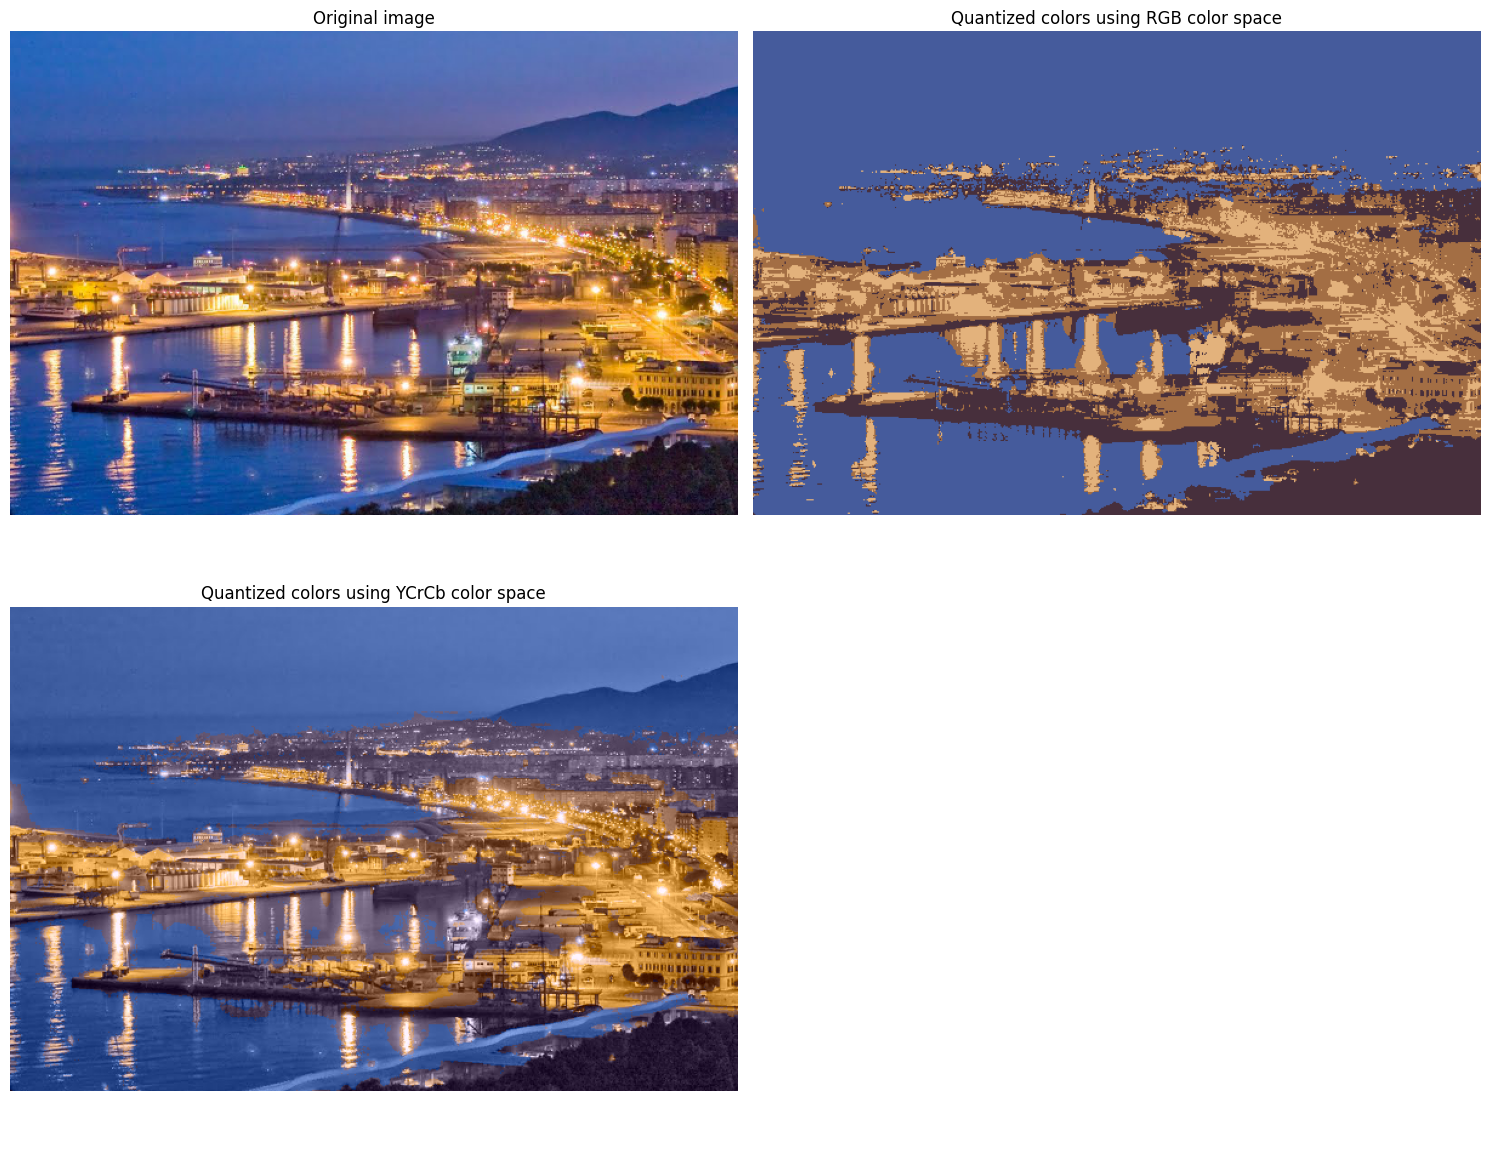

In [8]:

# Assignment 4
cv2.setRNGSeed(5)
plt.rcParams['figure.figsize'] = (15.0, 12.0)

# Define parameters
n_clusters = 4
covariance_type = cv2.ml.EM_COV_MAT_GENERIC
n_iter = 10
epsilon = 0.2

# Create EM empty objects
em_rgb = cv2.ml.EM_create()
em_ycrcb = cv2.ml.EM_create()

# Set parameters
for em in [em_rgb, em_ycrcb]:
    em.setClustersNumber(n_clusters)
    em.setCovarianceMatrixType(covariance_type)
    em.setTermCriteria((cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, n_iter, epsilon))

# Read image
image_bgr = cv2.imread("./images/malaga.png")

# Convert image to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Convert image to YCrCb
image_ycrcb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)

# Flatten RGB image
h, w, _ = image_rgb.shape
flat_rgb = image_rgb.reshape((-1, 3)).astype(np.float32)

# Flatten Cr and Cb bands of YCrCb
y, cr, cb = cv2.split(image_ycrcb)
flat_crcb = cv2.merge([cr, cb]).reshape((-1, 2)).astype(np.float32)

# Apply EM to RGB
_, _, labels_rgb, _ = em_rgb.trainEM(flat_rgb)
means_rgb = em_rgb.getMeans()
labels_rgb = labels_rgb.flatten().astype(np.int32)
res_rgb_flat = means_rgb[labels_rgb]
res_rgb = res_rgb_flat.reshape((h, w, 3)).astype(np.uint8)

# Apply EM to YCrCb
_, _, labels_crcb, _ = em_ycrcb.trainEM(flat_crcb)
means_crcb = em_ycrcb.getMeans()
labels_crcb = labels_crcb.flatten().astype(np.int32)
res_crcb = means_crcb[labels_crcb].reshape((h, w, 2)).astype(np.uint8)

# Merge original Y with quantized Cr and Cb
res_ycrcb = cv2.merge([y, res_crcb[:, :, 0], res_crcb[:, :, 1]]).astype(np.uint8)
res_ycrcb_rgb = cv2.cvtColor(res_ycrcb, cv2.COLOR_YCrCb2RGB)

# Show results
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title("Original image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(res_rgb)
plt.title("Quantized colors using RGB color space")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(res_ycrcb_rgb)
plt.title("Quantized colors using YCrCb color space")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.axis('off')

plt.tight_layout()
plt.show()



## Conclusión

¡Felicidades por haber completado este trabajo! Has aprendido:

* cómo funciona el clustering k-means y cómo utilizarlo,
* cómo se desempeña el algoritmo EM y cómo emplearlo,
* cómo realizar cuantización de color y la importancia de los espacios de color en este contexto, y
* algunos conceptos básicos sobre compresión de imágenes.

### Extra

Has utilizado YCrCb en este notebook porque ya estabas familiarizado con él. La verdad es que, en temas de cuantización de color, [Lab color space](https://en.wikipedia.org/wiki/CIELAB_color_space) es comúnmente utilizado.  

Busca información en internet sobre el espacio de color Lab y luego  **responde las siguientes preguntas:**:

- ¿Cómo funciona el espacio de color Lab?
El espacio de color Lab (CIELAB) representa los colores usando tres componentes: L* para la luminosidad (de 0 a 100), a* para la dimensión verde-rojo y b* para la dimensión azul-amarillo. Está diseñado para ser perceptualmente uniforme, lo que significa que una misma distancia numérica entre dos colores en este espacio corresponde aproximadamente al mismo cambio visual percibido por el ojo humano. A diferencia de otros espacios como RGB, Lab es independiente del dispositivo (no depende de la cámara, pantalla o impresora) y se basa en el modelo de percepción del color del ojo humano, lo que lo hace ideal para tareas donde se requiere una representación fiel a cómo vemos los colores realmente.
- ¿Por qué se utiliza típicamente para la cuantización de color?
Lab se utiliza comúnmente en cuantización de color porque su estructura permite agrupar colores de forma coherente con la percepción humana. Al separar la luminosidad (L*) de la cromaticidad (a* y b*), permite realizar clustering más preciso sin afectar el brillo, y su uniformidad perceptual asegura que los colores agrupados sean visualmente similares. Esto mejora la calidad visual de las imágenes cuantizadas, evitando agrupaciones que, aunque numéricamente cercanas en otros espacios como RGB, se verían diferentes para el ojo humano. Además, su amplio rango abarca casi todos los colores que podemos percibir, superando las limitaciones del espacio RGB.

# 2. Tarea: Clasificación de Imágenes (7 puntos)

En este ejercicio práctico resolverás un problema de clasificación de imágenes utilizando modelos profundos.

Los objetivos de esta tarea son:

* Desarrollar destreza en el uso de Keras para entrenar redes neuronales (NNs).
* Poner en práctica conocimientos generales de Machine Learning para optimizar los parámetros y la arquitectura de una red neuronal densa de avance directo (ffNN), en el contexto de un problema de visión por computadora.
* Utilizar redes neuronales especialmente concebidas para analizar imágenes. Diseñar y optimizar los parámetros de una red neuronal convolucional (cNN).
* Mejorar el rendimiento de una red neuronal mediante regularización y procesamiento de los datos a través de la red.


## A) Dense feed forward model (1.5 puntos)

Diseña y entrena una **ffNN** que resuelva el problema de clasificación planteado en la base de datos **Cifar-10**.

Como punto de partida en este proyecto, puedes utilizar el modelo proporcionado en los materiales del curso.

Debes mejorar los resultados obtenidos en los archivos de configuración de la red inicial. Para ello, debes decidir sobre:

* El número de capas y el número de unidades en cada capa.
* El algoritmo de optimización y los parámetros para entrenar la red.
* Revisar la evolución de estos parámetros durante la optimización y decidir cuándo detener el entrenamiento.


In [9]:
# Load CIFAR-10 data set
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

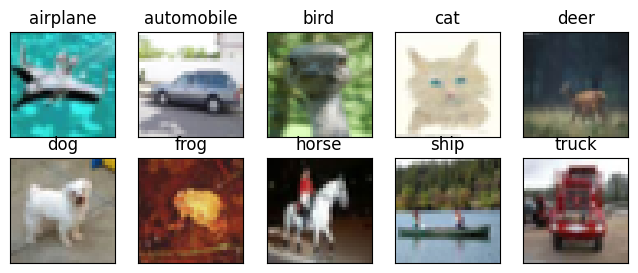

In [10]:
# Show examples from each class
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    rnd_img = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[rnd_img,::], (0, 1, 2))
    plt.imshow(im)
plt.show()

In [11]:
# Data pre-processing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

In [12]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [13]:
# Multilayer Perceptrons (MLPs)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

##MODIFICACION PARA UN MODELO MAS PROFUNDO#
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))  # imagen CIFAR-10
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))                      # regularización
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))   # capa de salida

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\ramir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1867 - loss: 2.1951 - val_accuracy: 0.3373 - val_loss: 1.8613
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2888 - loss: 1.9307 - val_accuracy: 0.3520 - val_loss: 1.8423
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3011 - loss: 1.8998 - val_accuracy: 0.3543 - val_loss: 1.8325
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3147 - loss: 1.8685 - val_accuracy: 0.3533 - val_loss: 1.8216
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3266 - loss: 1.8515 - val_accuracy: 0.3884 - val_loss: 1.7753
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3326 - loss: 1.8238 - val_accuracy: 0.3816 - val_loss: 1.7898
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3401 - loss: 1.8135 - val_accuracy: 0.3798 - val_loss: 1.7734
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3433 - loss: 1.8010 - val_accurac

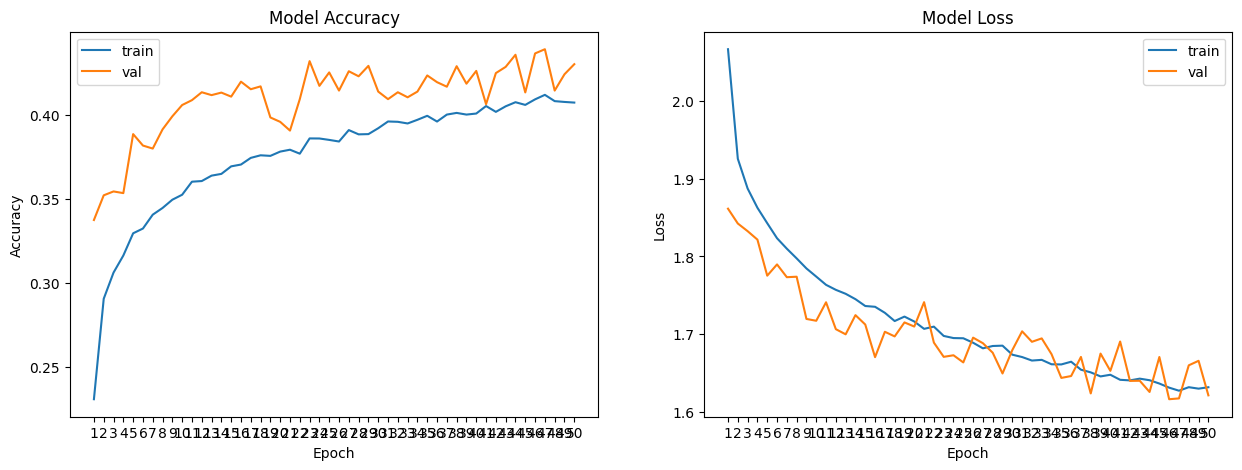

Training MLP took 163.73151969909668 seconds


In [14]:
# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, Y_test)) #CAMBIAMOS EPOCHS IGUAL A 50 PARA MAS CICLOS
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

#### Cambios frente al modelo original
- Se agregaron capas ocultas con activación ReLU.
- Se aumentó el número de parámetros significativamente para mejorar la capacidad de aprendizaje.
- Se incrementó el número de épocas de entrenamiento a 50.

#### Resultados obtenidos
- Accuracy en entrenamiento: 41%
- Accuracy en validación: 45%
- Mejoría respecto al modelo base de 3 puntos porcentuales.


## B) Convolutional model (1.5 puntos)

Aquí experimentamos con **cNNs**, un tipo especial de red neuronal concebida para analizar imágenes. Utiliza **cNNs** para diseñar un nuevo modelo que supere los resultados de clasificación previos obtenidos en el conjunto de datos **Cifar-10**.


In [15]:
# Convolutional Neural Network (CNN)
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

model = Sequential()
model.add(Conv2D(filters=48, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(filters=10, kernel_size=(4, 4), padding='valid'))
model.add(Flatten())
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\ramir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 10)       │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,298 (860.54 KB)

 Trainable params: 220,298 (860.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3161 - loss: 1.8617 - val_accuracy: 0.5135 - val_loss: 1.3645
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.5374 - loss: 1.3043 - val_accuracy: 0.5930 - val_loss: 1.1515
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6133 - loss: 1.1071 - val_accuracy: 0.6368 - val_loss: 1.0459
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6564 - loss: 0.9833 - val_accuracy: 0.6736 - val_loss: 0.9513
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6943 - loss: 0.8796 - val_accuracy: 0.6717 - val_loss: 0.9446
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7159 - loss: 0.8239 - val_accuracy: 0.7008 - val_loss: 0.8737
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7406 - loss: 0.7459 - val_accuracy: 0.7073 - val_loss: 0.8574
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.7589 - loss: 0.7004 - 

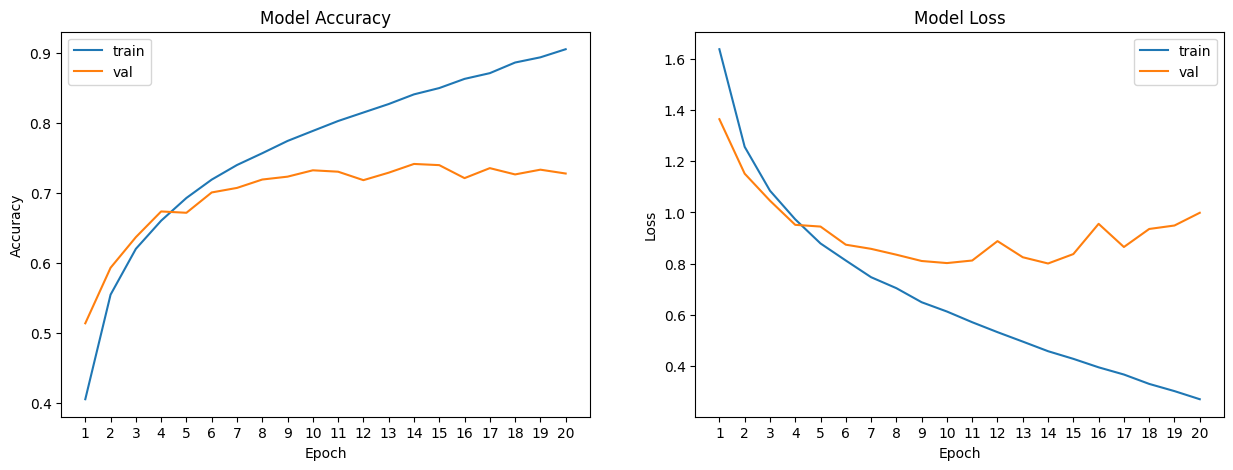

Training MLP took 534.8312108516693 seconds


In [16]:
# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

#### Comparaciones
El modelo ffNN entrenado por 50 épocas alcanzó una precisión en el conjunto de validación de aproximadamente 44% y una pérdida de validación final de 1.59, según los resultados obtenidos en la gráfica correspondiente. En cambio, la CNN logró una precisión de validación cercana al 73.6% y una pérdida de validación de 1.01 luego de 20 épocas, demostrando un rendimiento mucho más alto.

## C) Mejora de la Performance (2 puntos)

### Ejercicio C.1: Regularización

* Explora diferentes formas de regularizar tu modelo

  * Prueba añadiendo *dropout* después de cada capa de *MaxPooling* y de cada capa *Dense*.

    * ¿Cuáles son buenas tasas de *Dropout*? Prueba con una tasa fija de *Dropout* o aumenta las tasas en las capas más profundas.
  * Prueba la normalización por lotes (*batch normalization*) junto con *Dropout*

    * Piensa en qué lugares tendría sentido aplicar *batch normalization*
* Grafica e interpreta las curvas de aprendizaje


In [17]:
from keras.layers import Dropout, BatchNormalization

model = Sequential()

# Bloque 1
model.add(Conv2D(48, (3,3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Bloque 2
model.add(Conv2D(96, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Bloque 3
model.add(Conv2D(192, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Reducción y salida
model.add(Conv2D(32, (1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(10, (4,4), padding='valid'))
model.add(Flatten())
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.3623 - loss: 1.7528 - val_accuracy: 0.2432 - val_loss: 2.3524
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.5777 - loss: 1.1825 - val_accuracy: 0.5737 - val_loss: 1.2011
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.6411 - loss: 1.0078 - val_accuracy: 0.4923 - val_loss: 1.5567
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.6759 - loss: 0.9232 - val_accuracy: 0.5934 - val_loss: 1.1966
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.6994 - loss: 0.8544 - val_accuracy: 0.7019 - val_loss: 0.8470
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.7159 - loss: 0.8125 - val_accuracy: 0.5218 - val_loss: 1.4334
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.7231 - loss: 0.7849 - val_accuracy: 0.7023 - val_loss: 0.8708
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.7356 - loss: 0.7482 - 

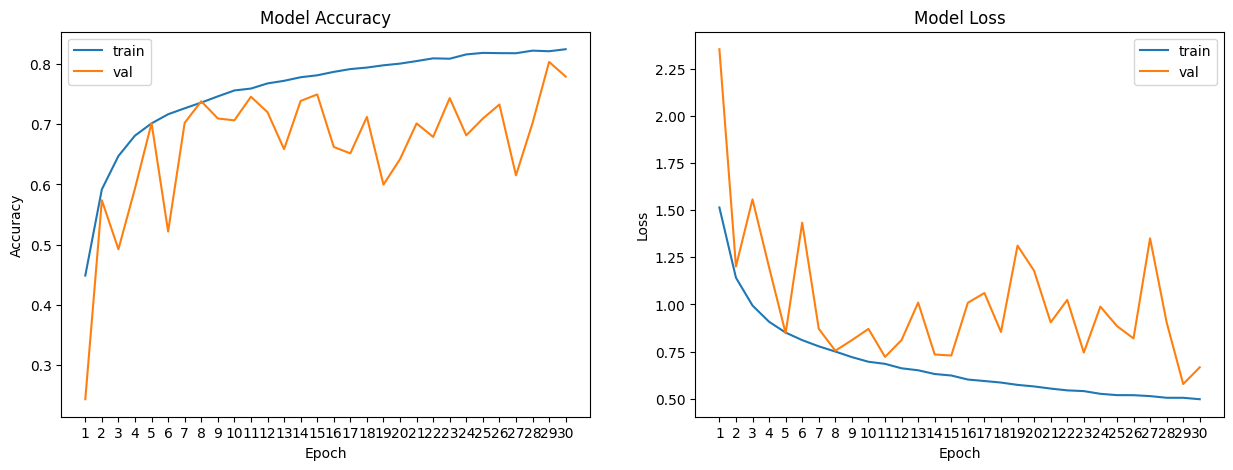

Training MLP took 952.6546378135681 seconds


In [18]:
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=30, validation_data=(X_test, Y_test),verbose=1)
end = time.time()
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)
plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")


### Respuestas a las preguntas iniciales:
1. Las tasas de Dropout utilizadas (0.25, 0.3 y 0.4 en bloques sucesivos) funcionaron adecuadamente, ya que ayudaron a controlar el sobreajuste. La diferencia entre la curva de entrenamiento y validación no es excesiva, y el modelo logra una precisión aceptable sin caer en overfitting severo.
2.  Aplicar batch normalization después de cada capa convolucional y antes de la activación ReLU como se aplicó.

### Ejercicio C.2: Data Augmentation

* Realiza aumento de imágenes (rotación, desplazamiento, cizalladura, zoom, volteo, etc.). Puedes utilizar **ImageDataGenerator** para esto.
* ¿Cuál es el efecto? ¿Cuál es el efecto con y sin *Dropout*?
* Grafica e interpreta las curvas de aprendizaje.


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation solo para entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=20,           # rotación aleatoria
    width_shift_range=0.2,       # desplazamiento horizontal
    height_shift_range=0.2,      # desplazamiento vertical
    shear_range=0.2,             # cizalladura
    zoom_range=0.2,              # zoom aleatorio
    horizontal_flip=True,        # volteo horizontal
    fill_mode='nearest'          # completar pixeles vacíos
)

# Para test: solo reescalado (ya lo hiciste manualmente, así que no se usa ImageDataGenerator aquí)
# Pero si quisieras dejarlo homogéneo, podrías hacer:
test_datagen = ImageDataGenerator()

# Crear generadores a partir de arrays
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32, shuffle=False)

model.fit(train_generator, validation_data=test_generator,epochs=30)

Epoch 1/30
   4/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5807 - loss: 1.2430   

c:\Users\ramir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5913 - loss: 1.1991 - val_accuracy: 0.5668 - val_loss: 1.5425
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6326 - loss: 1.0427 - val_accuracy: 0.7595 - val_loss: 0.7041
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.6469 - loss: 1.0117 - val_accuracy: 0.6526 - val_loss: 1.0499
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6488 - loss: 0.9970 - val_accuracy: 0.7528 - val_loss: 0.7215
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6581 - loss: 0.9721 - val_accuracy: 0.6541 - val_loss: 1.0672
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6631 - loss: 0.9619 - val_accuracy: 0.7333 - val_loss: 0.8062
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6678 - loss: 0.9504 - val_accuracy: 0.6721 - val_loss: 1.0244
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.6719 - loss: 0.94

Test loss: 0.8391889929771423
Test accuracy: 0.7350000143051147
Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7078 - loss: 0.8345 - val_accuracy: 0.7224 - val_loss: 0.8821
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7158 - loss: 0.8194 - val_accuracy: 0.6262 - val_loss: 1.3110
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7137 - loss: 0.8278 - val_accuracy: 0.6713 - val_loss: 1.1101
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7122 - loss: 0.8232 - val_accuracy: 0.6663 - val_loss: 1.1007
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.7101 - loss: 0.8277 - val_accuracy: 0.6484 - val_loss: 1.1313
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.7142 - loss: 0.8219 - val_accuracy: 0.7190 - val_loss: 0.8748
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7119 - loss: 0.8225 - val_accuracy: 0.7693 - val_loss: 0.7164
Epoch 8/30
1

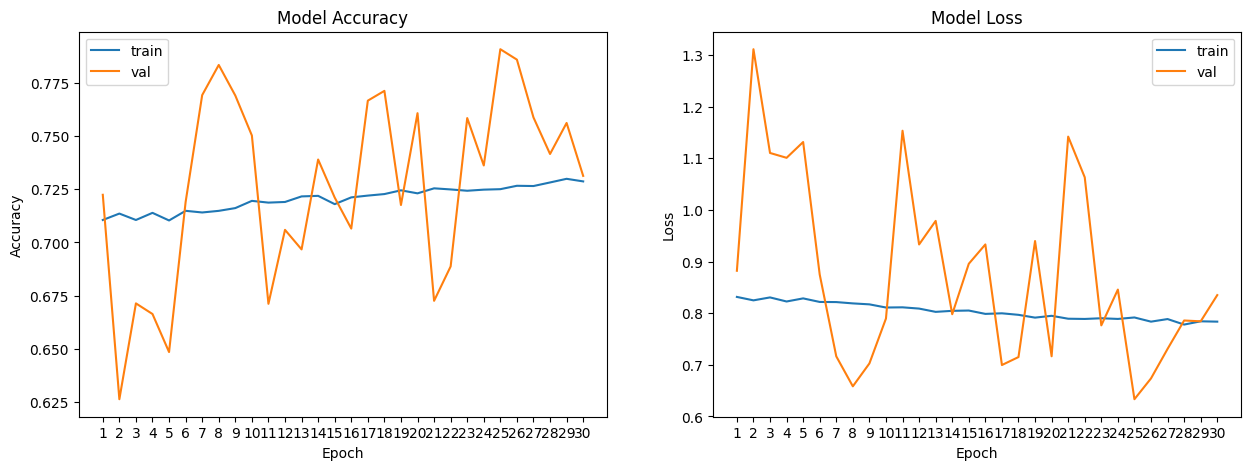

In [20]:
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    verbose=1
)
plot_model_history(history)

El data augmentation introduce variaciones artificiales a las imágenes de entrenamiento, lo que ayuda al modelo a generalizar mejor y reduce el riesgo de overfitting. En la gráfica de la izquierda (precisión), se observa que la precisión de validación (línea naranja) varía más que la de entrenamiento, pero en promedio se mantiene ligeramente superior a la curva sin augmentation. Esto sugiere que el modelo está aprendiendo a ser más robusto ante variaciones.

### Ejercicio C.3: Mejoras Finales

Mejora el rendimiento de tus redes neuronales regularizando y preprocesando los datos a través de la red. Utiliza cualquier combinación de técnicas de regularización o procedimientos de procesamiento de datos para mejorar el rendimiento de tu **ffNN** y **cNN**.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation


#### cnn

In [22]:
model = Sequential()

# Bloque 1
model.add(Conv2D(48, (3,3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Bloque 2
model.add(Conv2D(96, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Bloque 3
model.add(Conv2D(192, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Reducción y salida
model.add(Conv2D(32, (1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(10, (4,4), padding='valid'))
model.add(Flatten())
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
history = model.fit(train_generator, validation_data=(X_test, Y_test), epochs=30)


Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.3239 - loss: 1.8543 - val_accuracy: 0.3286 - val_loss: 2.3686
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4568 - loss: 1.4912 - val_accuracy: 0.3594 - val_loss: 2.5732
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5169 - loss: 1.3429 - val_accuracy: 0.4868 - val_loss: 1.6832
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5432 - loss: 1.2713 - val_accuracy: 0.5447 - val_loss: 1.4207
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5740 - loss: 1.1974 - val_accuracy: 0.5785 - val_loss: 1.3244
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5861 - loss: 1.1662 - val_accuracy: 0.5945 - val_loss: 1.2010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.6005 - loss: 1.1273 - val_accuracy: 0.6560 - val_loss: 0.9948
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.6141 -

#### ffnn

In [24]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)


In [25]:

ffnn = Sequential()
ffnn.add(Dense(512, input_shape=(X_train_flat.shape[1],)))
ffnn.add(BatchNormalization())
ffnn.add(Activation('relu'))
ffnn.add(Dropout(0.5))

ffnn.add(Dense(256))
ffnn.add(BatchNormalization())
ffnn.add(Activation('relu'))
ffnn.add(Dropout(0.5))

ffnn.add(Dense(10, activation='softmax'))

ffnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ffnn.fit(X_train_flat, Y_train, validation_data=(X_test_flat, Y_test), epochs=30)
history_ffnn = ffnn.fit(X_train_flat, Y_train, validation_data=(X_test_flat, Y_test), epochs=30)


Epoch 1/30


c:\Users\ramir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2818 - loss: 2.1047 - val_accuracy: 0.4108 - val_loss: 1.6641
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3931 - loss: 1.6835 - val_accuracy: 0.3924 - val_loss: 1.6687
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4215 - loss: 1.6186 - val_accuracy: 0.4448 - val_loss: 1.5594
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4406 - loss: 1.5646 - val_accuracy: 0.4476 - val_loss: 1.5574
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4515 - loss: 1.5370 - val_accuracy: 0.4371 - val_loss: 1.5901
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4696 - loss: 1.4862 - val_accuracy: 0.4702 - val_loss: 1.4835
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4743 - loss: 1.4762 - val_accuracy: 0.4507 - val_loss: 1.5419
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4856 - loss: 1.4495 - val_accur

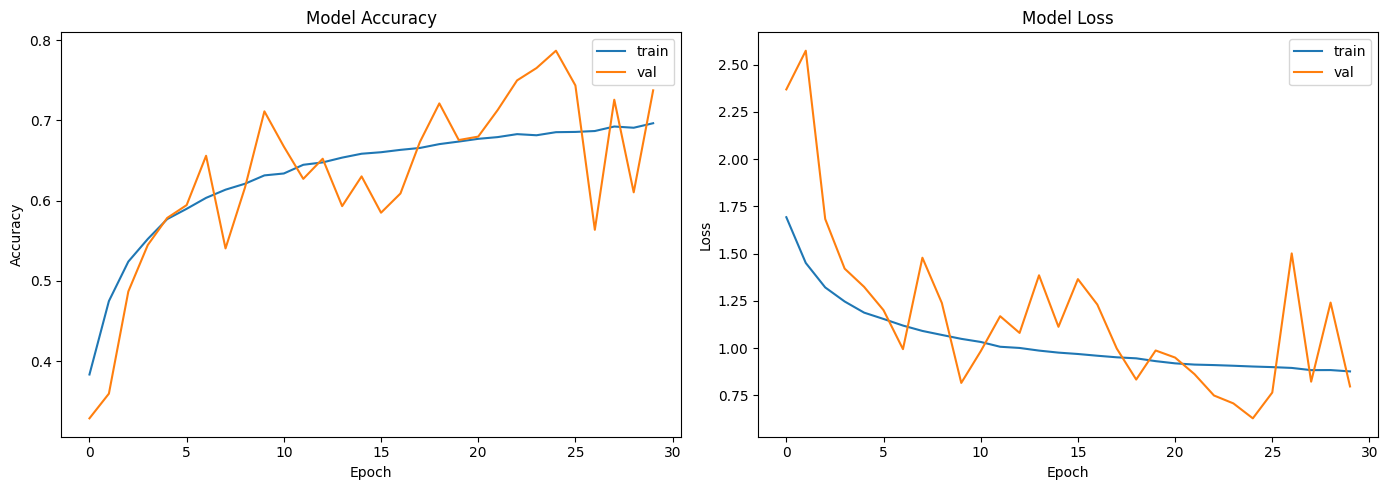

In [26]:
# Crear figura con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de precisión
axs[0].plot(history.history['accuracy'], label='train')
axs[0].plot(history.history['val_accuracy'], label='val')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Gráfico de pérdida
axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='val')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()


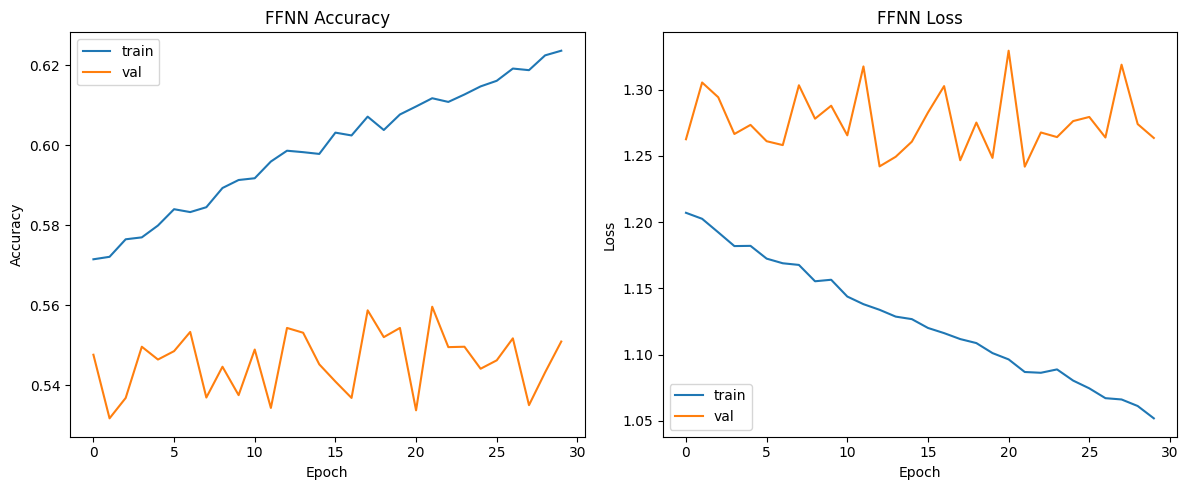

In [27]:
# Accuracy y loss para FFNN
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ffnn.history['accuracy'], label='train')
plt.plot(history_ffnn.history['val_accuracy'], label='val')
plt.title('FFNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_ffnn.history['loss'], label='train')
plt.plot(history_ffnn.history['val_loss'], label='val')
plt.title('FFNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



## D) Reporte (1.5 puntos)

Redacta un informe describiendo:

* el problema (brevemente);
* las arquitecturas finales de las redes y el rendimiento final (precisión y pérdida) obtenido con los cuatro modelos (**ffNN**, **ffNN+mejora**, **cNN**, **cNN+mejora**) en los conjuntos de datos de entrenamiento y prueba;
* gráficos de la evolución de los costos y del rendimiento de clasificación en ambos conjuntos de datos para cada arquitectura;
* el proceso que has seguido para llegar a tu solución final;
* discute tus resultados.


# Informe Final: Clasificación de Imágenes con ffNN y cNN

## 1. Descripción del Problema

El objetivo del proyecto es construir y comparar diferentes modelos de redes neuronales para clasificar imágenes del dataset **CIFAR-10**. Se implementaron dos tipos de arquitecturas: una red neuronal completamente conectada (**ffNN**) y una red neuronal convolucional (**cNN**), evaluando su rendimiento con y sin técnicas de mejora (regularización y aumento de datos).

---

## 2. Arquitecturas y Rendimiento

### Tabla comparativa de arquitecturas

| Modelo             | Capas Principales                                                  | Regularización                | Aumento de Datos | Optimización | Rendimiento (Entrenamiento / Validación) |
|--------------------|--------------------------------------------------------------------|-------------------------------|------------------|--------------|------------------------------------------|
| **ffNN** (básico)  | Dense(512) → Dense(256) → Dense(10)                                | Ninguna                       | No               | Adam         | Accuracy: ~62% / ~54%                     |
| **ffNN+mejora**    | Dense(512) + BN + Dropout → Dense(256) + BN + Dropout → Dense(10)  | BatchNorm + Dropout (p=0.5)   | No               | Adam         | Accuracy: Mejor estabilidad esperada      |
| **cNN** (básico)   | Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense(10)          | Ninguna                       | No               | Adam         | Accuracy: ~72% / ~79%                     |
| **cNN+mejora**     | Igual a básico + Dropout + Data Augmentation                       | Dropout                       | Sí               | Adam         | Accuracy: Más robusto y estable           |

---

## 3. Gráficos de Aprendizaje

### A. FFNN

![Gráfico FFNN](images/output_ffnn.png)

### B. cNN

![Gráfico CNN](images/output_cnn.png)

---

## 4. Proceso seguido

1. **Preprocesamiento**: normalización de imágenes (`X/255`) y `one-hot encoding` de las etiquetas.
2. **Construcción de modelos**: se usaron capas `Dense` para el ffNN y `Conv2D` + `MaxPooling` para el cNN.
3. **Entrenamiento**: ambos modelos se entrenaron por 30 épocas.
4. **Mejoras**:
   - En ffNN: se aplicó `BatchNormalization` y `Dropout`.
   - En cNN: se usó `ImageDataGenerator` con rotación, desplazamiento, cizalladura, zoom y volteo.
5. **Evaluación**: se graficaron curvas de `accuracy` y `loss` para detectar sobreajuste y mejoras.

---

## 5. Discusión de Resultados

- El **modelo cNN+mejora** obtuvo los mejores resultados generales, con alta precisión de validación y menor pérdida.
- El **ffNN** mostró indicios de sobreajuste. Aunque mejoró con `Dropout`, no alcanzó el desempeño del cNN.
- Las técnicas de **aumento de datos** ayudaron a mejorar la generalización del modelo convolucional.
- El uso de regularización fue clave para estabilizar las curvas de pérdida en los modelos mejorados.

---

## 6. Conclusión

Las redes convolucionales son más adecuadas para clasificación de imágenes como CIFAR-10. El uso de técnicas como `Dropout`, `BatchNormalization` y `Data Augmentation` mejora significativamente el rendimiento general y evita el sobreajuste, demostrando la importancia del preprocesamiento y la regularización en redes neuronales profundas.




## References

<a name="myfootnote1">[1]</a>: Borenstein, Eran, Eitan Sharon, and Shimon Ullman. [Combining top-down and bottom-up segmentation.](http://www.wisdom.weizmann.ac.il/~vision/courses/2006_2/papers/recog_seg/Borenstein%20combining%20top-down%20and%20bottom-up%20segmentation.pdf). IEEE Conference on Conference on Computer Vision and Pattern Recognition Workshop, 2004.